In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix



In [142]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)
df.head()

,kmeans_dist,kmeans_cluster,dbscan_cluster,pca_1,pca_2,anomaly_score,nearest_cosine_similarity,dengue
0,0.807903,1.00,0.000000,0.690117,0.530614,1.0,0.248749,1.0
1,0.872944,0.25,0.000378,0.548990,0.361146,1.0,0.372575,0.0
2,0.811521,0.00,0.000755,0.402503,0.733854,1.0,0.528842,0.0
3,0.809303,1.00,0.001133,0.472950,0.346633,0.0,0.441506,0.0
4,0.815355,0.00,0.001511,0.601353,0.324567,1.0,0.329382,1.0


In [143]:
len(df)

9386

In [144]:
X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [145]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 64)
        self.layer5 = nn.Linear(64, 32)
       

        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)

        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x=self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x=self.dropout1(x)
        x = torch.relu(self.layer3(x))
        x=self.dropout1(x)
        x = torch.relu(self.layer4(x))
        x=self.dropout2(x)
        x = torch.relu(self.layer5(x))
        #x=self.dropout2(x)
        #x = torch.relu(self.layer6(x))
        #x=self.dropout2(x)
        #x = torch.relu(self.layer7(x))
        x = torch.sigmoid(self.output_layer(x)) 
        return x

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DNN(input_dim=X_train_tensor.shape[1]).to(device)

criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch [1/200], Loss: 0.6141
Epoch [2/200], Loss: 0.5741
Epoch [3/200], Loss: 0.5646
Epoch [4/200], Loss: 0.5581
Epoch [5/200], Loss: 0.5584
Epoch [6/200], Loss: 0.5537
Epoch [7/200], Loss: 0.5537
Epoch [8/200], Loss: 0.5514
Epoch [9/200], Loss: 0.5490
Epoch [10/200], Loss: 0.5494
Epoch [11/200], Loss: 0.5485
Epoch [12/200], Loss: 0.5509
Epoch [13/200], Loss: 0.5455
Epoch [14/200], Loss: 0.5469
Epoch [15/200], Loss: 0.5439
Epoch [16/200], Loss: 0.5454
Epoch [17/200], Loss: 0.5450
Epoch [18/200], Loss: 0.5444
Epoch [19/200], Loss: 0.5451
Epoch [20/200], Loss: 0.5416
Epoch [21/200], Loss: 0.5434
Epoch [22/200], Loss: 0.5432
Epoch [23/200], Loss: 0.5433
Epoch [24/200], Loss: 0.5435
Epoch [25/200], Loss: 0.5421
Epoch [26/200], Loss: 0.5402
Epoch [27/200], Loss: 0.5428
Epoch [28/200], Loss: 0.5432
Epoch [29/200], Loss: 0.5422
Epoch [30/200], Loss: 0.5401
Epoch [31/200], Loss: 0.5414
Epoch [32/200], Loss: 0.5404
Epoch [33/200], Loss: 0.5407
Epoch [34/200], Loss: 0.5405
Epoch [35/200], Loss: 0

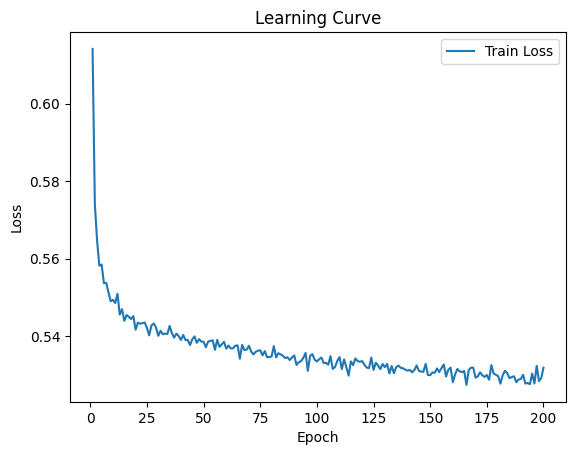

In [147]:
# トレーニング
num_epochs = 200
batch_size = 2
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# 学習曲線の描画
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Accuracy: 67.20%
Precision: 0.5144
Recall: 0.3126
F1 Score: 0.3889


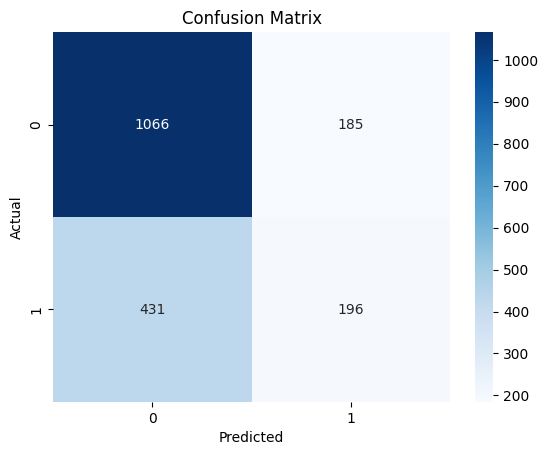

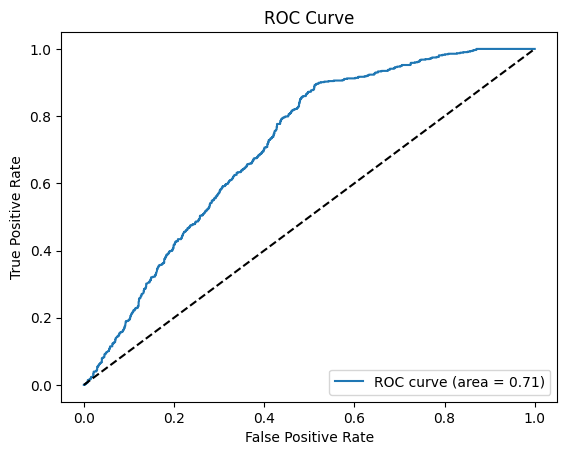

In [148]:
# 評価
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)
    
    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs > 0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

    # 精度、適合率、再現率、F1スコア
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # 45度線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


最適な閾値: 0.3100, F1スコア: 0.6125
Accuracy: 62.14%
Precision: 0.4652
Recall: 0.8963
F1 Score: 0.6125


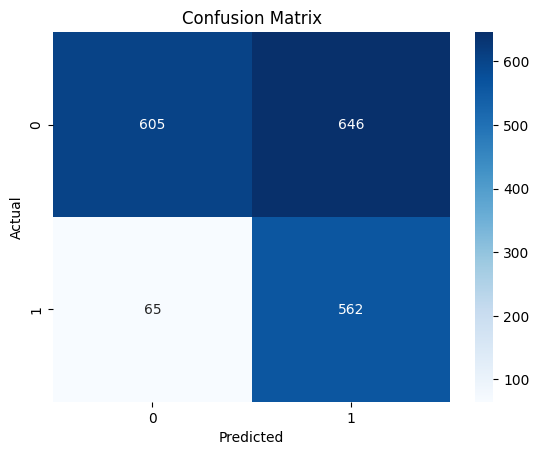

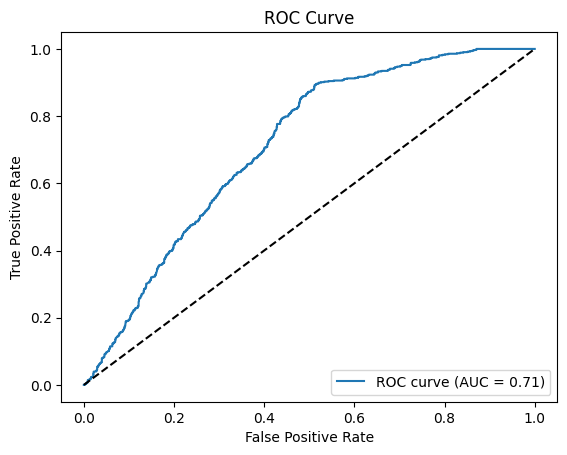

In [151]:
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

# 評価
model.eval()
with torch.no_grad():
    # データをGPUに移行
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()  # モデルからの出力
    y_true = y_test_tensor.cpu().numpy()           # 実際のラベル
    y_prob = test_outputs.cpu().numpy()            # 予測確率

    # 最適な閾値の探索 (例: 0.5を初期値にして精度を確認する)
    optimal_threshold = 0.5  # 初期の閾値
    f1_scores = []
    thresholds = []

    # さまざまな閾値でのF1スコアを計算し、最適なものを見つける
    for threshold in np.linspace(0.0, 1.0, num=101):  # 0.0から1.0までを0.01刻みで
        predictions = (y_prob >= threshold).astype(float)  # 閾値での予測
        f1 = f1_score(y_true, predictions)
        f1_scores.append(f1)
        thresholds.append(threshold)
    
    # 最適なF1スコアとその閾値を取得
    max_f1 = max(f1_scores)
    optimal_threshold = thresholds[f1_scores.index(max_f1)]
    print(f"最適な閾値: {optimal_threshold:.4f}, F1スコア: {max_f1:.4f}")

    # 最適な閾値での予測
    y_pred = (y_prob >= optimal_threshold).astype(float)
    
    # 精度、適合率、再現率、F1スコア
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 混同行列
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # 45度線
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
